LangGraph 工具调用

第一步：使用@tool修饰符创建工具
第二步：绑定工具到模型
第三步：工具调用：将自然语言转为正确的参数
第四步：工具执行：将工具执行并将结果传递给下一步

### 工具定义

In [ ]:
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

from langgraph.prebuilt import ToolNode


@tool
def get_weather(location: str) -> str:
    """调用此函数获取当前天气"""
    if location.lower() in ["北京", "深圳"]:
        return "现在是20度，有雾。"
    else:
        return "现在是10度，晴朗。"


@tool
def get_coolest_cities():
    """获取最冷的城市列表"""
    return "哈尔滨, 北京"


tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'runtime': ('N/A', <class 'inspect._empty'>)}, _tools_by_name={'get_weather': StructuredTool(name='get_weather', description='调用此函数获取当前天气', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x79f1a0584f40>), 'get_coolest_cities': StructuredTool(name='get_coolest_cities', description='获取最冷的城市列表', args_schema=<class 'langchain_core.utils.pydantic.get_coolest_cities'>, func=<function get_coolest_cities at 0x79f1a0585580>)}, _injected_args={'get_weather': _InjectedArgs(state={}, store=None, runtime=None), 'get_coolest_cities': _InjectedArgs(state={}, store=None, runtime=None)}, _handle_tool_errors=<function _default_handle_tool_errors at 0x79f1a22f4360>, _messages_key='messages', _wrap_tool_call=None, _awrap_tool_call=None)


In [ ]:
for t in tools:
    print(f"Tool: {t.name}")
    print(f"Args: {t.args}")

In [31]:
# langgraph提供了底层面的封装，可以直接手动执行工具

# 自己构造调用方法消息
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_weather",
            "args": {"location": "北京"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

ValueError: Missing required config key 'N/A' for 'tools'.

### 工具绑定

In [23]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv(".env", override=True)

model = ChatOpenAI(
    model=os.environ.get("DEEPSEEK_MODEL"),
    base_url=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)

# 绑定工具
bound_model = model.bind_tools(tools)

In [ ]:
# 转换为工具调用
bound_model.invoke("深圳天气如何？").tool_calls

AIMessage(content='我来帮您查询深圳的天气情况。', additional_kwargs={'tool_calls': [{'id': 'call_00_UH9VOOKmxnksqciaziYtD6Gg', 'function': {'arguments': '{"location": "深圳"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 337, 'total_tokens': 389, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 320}, 'prompt_cache_hit_tokens': 320, 'prompt_cache_miss_tokens': 17}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '05b7594a-9155-4f12-90b1-92570598a30a', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b8860-4269-7b10-b585-7d68a8c159e0-0', tool_calls=[{'name': 'get_weather', 'args': {'location': '深圳'}, 'id': 'call_00_UH9VOOKmxnksqciaziYtD6Gg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 337, 'output_tokens': 52, 'total_tokens': 389, 'input_token_detail

In [25]:
# 执行工具，返回ToolMessage
tool_node.invoke({"messages": [bound_model.invoke("深圳天气如何？")]})

ValueError: Missing required config key 'N/A' for 'tools'.

### 在ReAct智能体中执行

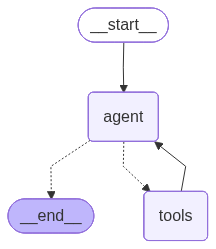

In [26]:
from langgraph.graph import StateGraph, START, END, MessagesState
from IPython.display import Image, display


def should_continue(state: MessagesState):
    """终止条件"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"

    return END


def call_model(state: MessagesState):
    """调用模型"""
    messages = state["messages"]
    response = bound_model.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
for chunk in app.stream(
    {"messages": [HumanMessage(content="深圳天气如何？")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

深圳天气如何？
================================== Ai Message ==================================

我来帮您查询深圳的天气情况。
Tool Calls:
  get_weather (call_00_aBAZ7wHyy14m1XAEWrtqrv3X)
 Call ID: call_00_aBAZ7wHyy14m1XAEWrtqrv3X
  Args:
    location: 深圳
================================= Tool Message =================================
Name: get_weather

现在是20度，有雾。
================================== Ai Message ==================================

根据查询结果，深圳现在的天气情况是：
- 温度：20°C
- 天气状况：有雾

今天深圳的天气比较温和，但因为有雾，能见度可能不太好，如果您需要外出，请注意交通安全。


In [28]:
for chunk in app.stream(
    {"messages": [HumanMessage(content="最冷的城市天气如何？")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

最冷的城市天气如何？
================================== Ai Message ==================================

我可以帮您查询最冷城市的天气情况。首先让我获取最冷的城市列表，然后为您查询这些城市的天气。
Tool Calls:
  get_coolest_cities (call_00_S9aDeki62Y9WwVhUVZX4sJG8)
 Call ID: call_00_S9aDeki62Y9WwVhUVZX4sJG8
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

哈尔滨, 北京
================================== Ai Message ==================================

现在我来查询这两个最冷城市的天气情况：
Tool Calls:
  get_weather (call_00_cj9x6bHL9VM1y9RXTxZtrRNE)
 Call ID: call_00_cj9x6bHL9VM1y9RXTxZtrRNE
  Args:
    location: 哈尔滨
  get_weather (call_01_SwTvKYbC6pp0bkMi773i5PYx)
 Call ID: call_01_SwTvKYbC6pp0bkMi773i5PYx
  Args:
    location: 北京
================================= Tool Message =================================
Name: get_weather

现在是20度，有雾。
================================== Ai Message ==================================

根据查